In [1]:
!python --version

Python 3.10.18


In [2]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

# Librerías para deep learning (simulando con sklearn por compatibilidad)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, ClassifierMixin

# Deep learning
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.models import save_model

import joblib  # Para guardar modelos como fusion_model o scaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
class AdaptedCrimePredictionModel:
    
    def __init__(self, spatial_clusters=15, temporal_window=30, attention_features=10):
        self.spatial_clusters = spatial_clusters
        self.temporal_window = temporal_window
        self.attention_features = attention_features
        
        # Componentes del modelo híbrido
        self.spatial_clusterer = None
        self.temporal_analyzer = None
        self.attention_weights = None
        self.fusion_model = None
        self.rnn_model = None

        # Scalers y encoders
        self.scaler = StandardScaler()
        self.label_encoders = {}

        # Métricas de rendimiento
        self.performance_metrics = {}
        self.num_classes = None
        self.is_trained = False

    def create_temporal_sequences(self, df, sequence_length=30):
        """
        Crear secuencias temporales de crímenes por cluster espacial
        para alimentar una RNN como LSTM o GRU.
        """
        print("Creando secuencias temporales para la RNN...")

        df = df.sort_values(['spatial_cluster', 'datetime']).reset_index(drop=True)
        sequence_data = []
        sequence_labels = []

        clusters = df['spatial_cluster'].unique()
        for cluster in clusters:
            cluster_df = df[df['spatial_cluster'] == cluster]
            if len(cluster_df) < sequence_length:
                continue

            temporal_features = ['crime_count_7d', 'crime_count_30d', 'temporal_weight']

            for i in range(len(cluster_df) - sequence_length):
                sequence = cluster_df.iloc[i:i+sequence_length][temporal_features].values
                label = cluster_df.iloc[i+sequence_length]['NIBRS_Offense_encoded']
                sequence_data.append(sequence)
                sequence_labels.append(label)

        return np.array(sequence_data), np.array(sequence_labels)

    def build_rnn_model(self, input_shape):
        """
        Construir modelo RNN (LSTM) con API funcional de Keras.
        """
        from tensorflow.keras.models import Model
        from tensorflow.keras.layers import Input, LSTM, Dense
    
        inputs = Input(shape=input_shape, name="input_sequence")
        x = LSTM(64, return_sequences=False, name="lstm")(inputs)
        x = Dense(64, activation='relu', name="dense_embedding")(x)
        outputs = Dense(self.num_classes, activation='softmax', name="output")(x)
    
        model = Model(inputs=inputs, outputs=outputs, name="HybridRNN")
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model


    def train_rnn_model(self, X_seq, y_seq):
        """
        Entrenar modelo RNN y extraer embeddings.
        """
        from tensorflow.keras.models import Model
    
        print("Entrenando RNN (LSTM)...")
        self.num_classes = len(np.unique(y_seq))
        self.rnn_model = self.build_rnn_model(input_shape=(X_seq.shape[1], X_seq.shape[2]))
        self.rnn_model.fit(X_seq, y_seq, epochs=10, batch_size=32, verbose=1)
    
        # Extraer embeddings desde la capa con nombre "dense_embedding"
        embedding_model = Model(
            inputs=self.rnn_model.input,
            outputs=self.rnn_model.get_layer("dense_embedding").output
        )
        embeddings = embedding_model.predict(X_seq)
        return embeddings


    def train_combined_model(self, X_context, rnn_embeddings, y):
        """Entrenar modelo combinado (Random Forest + RNN embeddings)"""
        print("Entrenando modelo combinado (Random Forest + RNN embeddings)...")
    
        # Eliminar columnas datetime
        datetime_cols = X_context.select_dtypes(include=['datetime']).columns
        if len(datetime_cols) > 0:
            print(f"Eliminando columnas datetime para entrenamiento: {list(datetime_cols)}")
            X_context_clean = X_context.drop(columns=datetime_cols)
        else:
            X_context_clean = X_context.copy()
    
        # Escalar características contextuales
        X_context_scaled = self.scaler.fit_transform(X_context_clean)
        
        # Combinar características contextuales escaladas + embeddings RNN
        X_combined = np.hstack([X_context_scaled, rnn_embeddings])
    
        # Configurar y entrenar Random Forest
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import GridSearchCV
        
        param_grid = {
            'n_estimators': [100],              # Antes: [100, 200]
            'max_depth': [10, None],            # Antes: [10, 20, None]
            'min_samples_split': [2],           # Antes: [2, 5]
            'min_samples_leaf': [1],            # Antes: [1, 2]
            'class_weight': ['balanced']        # Mantenido
        }

    
        grid_search = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
            param_grid=param_grid,
            scoring='f1_weighted',
            cv=3,
            verbose=2,
            n_jobs=-1
        )
    
        grid_search.fit(X_combined, y)
        self.fusion_model = grid_search.best_estimator_
        self.is_trained = True
    
        print(f"\n✅ Mejor modelo combinado encontrado: {grid_search.best_params_}")
        # 🔍 Evaluación del rendimiento del modelo
        from sklearn.metrics import confusion_matrix, classification_report
        y_pred = grid_search.predict(X_combined)
        print("\n🔍 Classification Report:")
        print(classification_report(y, y_pred, zero_division=0))
    
    def predict_combined(self, X_context, rnn_embeddings):
        """Realizar predicciones con el modelo combinado"""
        if not self.is_trained:
            raise ValueError("El modelo no ha sido entrenado. Llama a train_combined_model() primero.")
            
        # Limpiar columnas datetime
        datetime_cols = X_context.select_dtypes(include=['datetime']).columns
        if len(datetime_cols) > 0:
            X_context_clean = X_context.drop(columns=datetime_cols)
        else:
            X_context_clean = X_context.copy()
            
        # Escalar y combinar
        X_context_scaled = self.scaler.transform(X_context_clean)
        X_combined = np.hstack([X_context_scaled, rnn_embeddings])
        
        return self.fusion_model.predict(X_combined)
    
    def evaluate_combined_model(self, X_context, rnn_embeddings, y_true):
        """Evaluar modelo combinado"""
        from sklearn.metrics import accuracy_score, f1_score
        
        y_pred = self.predict_combined(X_context, rnn_embeddings)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        print(f"Accuracy combinado: {accuracy:.4f}")
        print(f"F1-Score combinado: {f1:.4f}")
        
        return {"accuracy": accuracy, "f1_score": f1}
    
    def full_training_pipeline(self, df_contextual):
        """Pipeline completo de entrenamiento"""
        print("=== Iniciando pipeline de entrenamiento completo ===")
        
        # 1. Preparar características contextuales y objetivo
        X_context, y_context = self.prepare_features_target(df_contextual)
        
        # 2. Crear secuencias temporales para RNN
        X_seq, y_seq = self.create_temporal_sequences(df_contextual, self.temporal_window)
        
        if len(X_seq) == 0:
            raise ValueError("No se pudieron crear secuencias temporales. Verifica los datos.")
        
        # 3. Entrenar RNN y extraer embeddings
        rnn_embeddings = self.train_rnn_model(X_seq, y_seq)
        
        # 4. Alinear datos (importante: solo usar los registros que tienen secuencias)
        # Necesitamos mapear los embeddings con los datos contextuales correctos
        valid_indices = self._get_valid_sequence_indices(df_contextual, self.temporal_window)
        X_context_aligned = X_context.iloc[valid_indices].reset_index(drop=True)
        y_context_aligned = y_context.iloc[valid_indices].reset_index(drop=True)
        
        # 5. Aplicar SMOTE para balancear clases
        from imblearn.over_sampling import BorderlineSMOTE
        
        # Eliminar columnas datetime antes de SMOTE
        datetime_cols = X_context_aligned.select_dtypes(include=['datetime']).columns
        X_context_clean = X_context_aligned.drop(columns=datetime_cols) if len(datetime_cols) > 0 else X_context_aligned
        
        # Escalar antes de SMOTE
        X_context_scaled = self.scaler.fit_transform(X_context_clean)
        X_combined = np.hstack([X_context_scaled, rnn_embeddings])
        
        smote = BorderlineSMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_combined, y_context_aligned)
        
        # 6. Entrenar modelo final con datos balanceados
        # Separar de nuevo las características contextuales y embeddings
        n_context_features = X_context_scaled.shape[1]
        X_context_resampled = X_resampled[:, :n_context_features]
        rnn_embeddings_resampled = X_resampled[:, n_context_features:]
        
        # Crear DataFrame para compatibilidad
        X_context_resampled_df = pd.DataFrame(X_context_resampled, columns=X_context_clean.columns)
        
        self.train_combined_model(X_context_resampled_df, rnn_embeddings_resampled, y_resampled)
        
        print("✅ Pipeline de entrenamiento completado exitosamente")
        return X_context_aligned, rnn_embeddings, y_context_aligned

    def _get_valid_sequence_indices(self, df, sequence_length):
        """Obtener índices válidos que tienen secuencias temporales correspondientes"""
        df_sorted = df.sort_values(['spatial_cluster', 'datetime']).reset_index(drop=True)
        valid_indices = []
        
        clusters = df_sorted['spatial_cluster'].unique()
        for cluster in clusters:
            cluster_df = df_sorted[df_sorted['spatial_cluster'] == cluster]
            if len(cluster_df) < sequence_length:
                continue
                
            # Los índices válidos son desde sequence_length hasta el final
            cluster_indices = cluster_df.index[sequence_length:].tolist()
            valid_indices.extend(cluster_indices)
            
        return valid_indices

    def predict_future_crimes(self, df_contextual, days_ahead=7):
        """Predecir crímenes futuros usando el modelo entrenado"""
        if not self.is_trained:
            raise ValueError("El modelo no ha sido entrenado.")
            
        print(f"\n🔮 Prediciendo crímenes para los próximos {days_ahead} días...")
        future_data = []
    
        for cluster_id in df_contextual['spatial_cluster'].unique():
            cluster_df = df_contextual[df_contextual['spatial_cluster'] == cluster_id]
            cluster_df = cluster_df.sort_values('datetime')
    
            # Verificar que hay suficientes datos
            if len(cluster_df) < self.temporal_window:
                continue
    
            # Usar los datos más recientes para crear secuencia
            recent_seq = cluster_df.tail(self.temporal_window)
            temporal_features = ['crime_count_7d', 'crime_count_30d', 'temporal_weight']
            sequence = recent_seq[temporal_features].values[np.newaxis, :, :]
    
            # Extraer embedding RNN
            from tensorflow.keras.models import Model
            intermediate_layer = Model(inputs=self.rnn_model.input, outputs=self.rnn_model.layers[-2].output)
            embedding = intermediate_layer.predict(sequence, verbose=0)
    
            # Preparar características contextuales
            context_features = ['crime_severity_score', 'temporal_weight', 'lat', 'lon'] 
            # Usar las características disponibles
            available_context = [col for col in context_features if col in recent_seq.columns]
            if not available_context:
                # Usar características por defecto si no están disponibles
                available_context = [col for col in recent_seq.columns if col in self.scaler.feature_names_in_][:4]
            
            if available_context:
                context_vector_df = pd.DataFrame([recent_seq[available_context].mean()])
            else:
                # Crear contexto mínimo si no hay características disponibles
                context_vector_df = pd.DataFrame([[0, 0, 0, 0]], columns=['feat1', 'feat2', 'feat3', 'feat4'])
    
            # Realizar predicción
            try:
                prediction = self.predict_combined(context_vector_df, embedding)
                future_data.append({
                    'spatial_cluster': cluster_id,
                    'predicted_crime': prediction[0]
                })
            except Exception as e:
                print(f"Error prediciendo para cluster {cluster_id}: {e}")
                continue
    
        return pd.DataFrame(future_data)


    def preprocess_real_data(self, df):
        """
        Preprocesamiento específico para el dataset real
        """
        print("Iniciando preprocesamiento de datos reales...")
        
        # Crear copia para evitar modificar el DataFrame original
        df = df.copy()
        
        # Limpiar y convertir fechas
        df['ReportDate'] = pd.to_datetime(df['ReportDate'], errors='coerce')
        df['OccurredFromDate'] = pd.to_datetime(df['OccurredFromDate'], errors='coerce')
        df['OccurredToDate'] = pd.to_datetime(df['OccurredToDate'], errors='coerce')
        
        # Usar OccurredFromDate como fecha principal
        df['datetime'] = df['OccurredFromDate'].fillna(df['ReportDate'])
        
        # Eliminar registros sin fecha válida
        df = df.dropna(subset=['datetime']).reset_index(drop=True)
        
        # Crear características temporales
        df['hour'] = df['datetime'].dt.hour
        df['day_of_week'] = df['datetime'].dt.dayofweek
        df['month'] = df['datetime'].dt.month
        df['day_of_year'] = df['datetime'].dt.dayofyear
        df['year'] = df['datetime'].dt.year
        df['quarter'] = df['datetime'].dt.quarter
        
        # Características cíclicas (importante para patrones temporales)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        
        # Codificar variables categóricas importantes
        categorical_columns = ['NIBRS_Offense', 'Part', 'Crime_Against', 'LocationType', 
                             'Zone', 'DISTRICT', 'NPU', 'NhoodName', 'Beat']
        
        for col in categorical_columns:
            if col in df.columns:
                # Limpiar datos categóricos
                df[col] = df[col].astype(str).fillna('Unknown')
                le = LabelEncoder()
                df[f'{col}_encoded'] = le.fit_transform(df[col])
                self.label_encoders[col] = le
        
        # Convertir variables booleanas de manera más robusta
        if 'FireArmInvolved' in df.columns:
            df['FireArmInvolved_binary'] = df['FireArmInvolved'].astype(str).str.lower().map({
                'yes': 1, 'true': 1, '1': 1, 'y': 1
            }).fillna(0).astype(int)
        else:
            df['FireArmInvolved_binary'] = 0
            
        if 'IsBiasMotivationInvolved' in df.columns:
            df['IsBiasMotivationInvolved_binary'] = pd.to_numeric(
                df['IsBiasMotivationInvolved'], errors='coerce'
            ).fillna(0).astype(int)
        else:
            df['IsBiasMotivationInvolved_binary'] = 0
        
        # Limpiar coordenadas (eliminar valores extremos)
        if 'Latitude' in df.columns and 'Longitude' in df.columns:
            df = df[(df['Latitude'] > 30) & (df['Latitude'] < 40)]  # Rango válido para Atlanta
            df = df[(df['Longitude'] > -90) & (df['Longitude'] < -80)]
            df = df.reset_index(drop=True)
        
        # Asegurar que Vic_Count sea numérico
        if 'Vic_Count' in df.columns:
            df['Vic_Count'] = pd.to_numeric(df['Vic_Count'], errors='coerce').fillna(1)
        else:
            df['Vic_Count'] = 1
        
        # Crear Zone_int si no existe
        if 'Zone' in df.columns and 'Zone_int' not in df.columns:
            df['Zone_int'] = df['Zone_encoded']
        elif 'Zone_int' not in df.columns:
            df['Zone_int'] = 0
        
        print(f"Datos preprocesados: {df.shape[0]} registros, {df.shape[1]} características")
        return df
    
    def create_crime_severity_score(self, df):
        """
        Crear un score de severidad del crimen basado en múltiples factores
        """
        print("Creando score de severidad del crimen...")
        
        # Score base por tipo de crimen (Part I crimes son más severos)
        if 'Part' in df.columns:
            df['part_severity'] = df['Part'].map({'Part I': 2, 'Part II': 1}).fillna(1)
        else:
            df['part_severity'] = 1
        
        # Score por arma de fuego involucrada
        df['firearm_severity'] = df['FireArmInvolved_binary'] * 2
        
        # Score por víctimas
        df['victim_severity'] = np.log1p(df['Vic_Count'])
        
        # Score por motivación de odio
        df['bias_severity'] = df['IsBiasMotivationInvolved_binary'] * 1.5
        
        # Score combinado
        df['crime_severity_score'] = (df['part_severity'] + 
                                    df['firearm_severity'] + 
                                    df['victim_severity'] + 
                                    df['bias_severity'])
        
        return df
    
    def enhanced_spatial_clustering(self, df):
        """
        Clustering espacial mejorado usando información geográfica real
        """
        print("Ejecutando clustering espacial mejorado...")
        
        if 'Latitude' not in df.columns or 'Longitude' not in df.columns:
            print("Coordenadas no disponibles, usando clustering simple")
            df['spatial_cluster'] = 0
            return df
        
        # Usar coordenadas reales
        spatial_features = df[['Latitude', 'Longitude']].values
        
        # DBSCAN con parámetros ajustados para datos reales de ciudad
        dbscan = DBSCAN(eps=0.005, min_samples=10)
        spatial_clusters = dbscan.fit_predict(spatial_features)
        
        # K-means como respaldo
        kmeans = KMeans(n_clusters=self.spatial_clusters, random_state=42, n_init=10)
        kmeans_clusters = kmeans.fit_predict(spatial_features)
        
        # Combinar resultados
        final_clusters = spatial_clusters.copy()
        outlier_mask = (spatial_clusters == -1)
        if np.any(outlier_mask):
            max_cluster = spatial_clusters.max() if spatial_clusters.max() >= 0 else 0
            final_clusters[outlier_mask] = kmeans_clusters[outlier_mask] + max_cluster + 1
        
        df['spatial_cluster'] = final_clusters
        self.spatial_clusterer = {'dbscan': dbscan, 'kmeans': kmeans}
        
        # Agregar información de zona administrativa como característica
        df['zone_cluster_consistency'] = (df['Zone_int'] == df['spatial_cluster']).astype(int)
        
        print(f"Identificados {len(np.unique(final_clusters))} clusters espaciales")
        return df

    def advanced_temporal_analysis(self, df):
        """
        Análisis temporal avanzado usando los campos de fecha reales
        """
        print("Ejecutando análisis temporal avanzado...")
        
        # Crear copia y asegurar orden temporal
        df_sorted = df.copy().sort_values('datetime').reset_index(drop=True)
        
        # Calcular conteos temporales de manera más robusta
        try:
            # Convertir a DataFrame con índice temporal para rolling
            df_temp = df_sorted.set_index('datetime')
            
            # Calcular rolling counts por cluster espacial
            rolling_counts = []
            for cluster in df_sorted['spatial_cluster'].unique():
                cluster_data = df_temp[df_temp['spatial_cluster'] == cluster]
                
                if len(cluster_data) > 0:
                    # Calcular conteos rolling
                    rolling_7d = cluster_data['OBJECTID'].rolling('7D').count()
                    rolling_30d = cluster_data['OBJECTID'].rolling('30D').count()
                    
                    # Crear DataFrame temporal
                    temp_df = pd.DataFrame({
                        'datetime': rolling_7d.index,
                        'spatial_cluster': cluster,
                        'crime_count_7d': rolling_7d.values,
                        'crime_count_30d': rolling_30d.values
                    })
                    rolling_counts.append(temp_df)
            
            # Combinar todos los conteos
            if rolling_counts:
                all_rolling = pd.concat(rolling_counts, ignore_index=True)
                
                # Hacer merge con el DataFrame original
                df_sorted = df_sorted.merge(
                    all_rolling, 
                    on=['datetime', 'spatial_cluster'], 
                    how='left'
                )
            else:
                df_sorted['crime_count_7d'] = 1
                df_sorted['crime_count_30d'] = 1
                
        except Exception as e:
            print(f"Error en análisis temporal: {e}")
            df_sorted['crime_count_7d'] = 1
            df_sorted['crime_count_30d'] = 1
        
        # Rellenar valores faltantes
        df_sorted['crime_count_7d'] = df_sorted['crime_count_7d'].fillna(1)
        df_sorted['crime_count_30d'] = df_sorted['crime_count_30d'].fillna(1)
        
        # Tiempo entre reporte y ocurrencia
        if 'ReportDate' in df_sorted.columns:
            df_sorted['report_delay_hours'] = (
                df_sorted['ReportDate'] - df_sorted['OccurredFromDate']
            ).dt.total_seconds() / 3600
            df_sorted['report_delay_hours'] = df_sorted['report_delay_hours'].fillna(0).clip(0, 24 * 30)
        else:
            df_sorted['report_delay_hours'] = 0
        
        # Duración del incidente
        if 'OccurredToDate' in df_sorted.columns:
            df_sorted['incident_duration_hours'] = (
                df_sorted['OccurredToDate'] - df_sorted['OccurredFromDate']
            ).dt.total_seconds() / 3600
            df_sorted['incident_duration_hours'] = df_sorted['incident_duration_hours'].fillna(0).clip(0, 24)
        else:
            df_sorted['incident_duration_hours'] = 0
        
        # Pesos de atención temporal
        df_sorted['temporal_weight'] = self._calculate_attention_weights(df_sorted)

        df_sorted['temporal_series'] = df_sorted.apply(lambda row: [
            row['crime_count_7d'],
            row['crime_count_30d'],
            row['temporal_weight']
        ], axis=1)
        
        return df_sorted
    
    def _calculate_attention_weights(self, df):
        """
        Calcular pesos de atención basados en recencia y patrones
        """
        current_time = df['datetime'].max()
        time_diff = (current_time - df['datetime']).dt.days
        
        # Peso exponencial decreciente con factor ajustado
        attention_weights = np.exp(-time_diff / 60)  # Decaimiento de 60 días
        
        # Ajustar por severidad del crimen
        if 'crime_severity_score' in df.columns:
            severity_factor = df['crime_severity_score'] / df['crime_severity_score'].max()
            attention_weights = attention_weights * (1 + severity_factor)
        
        # Normalizar por cluster espacial
        df_temp = df.copy()
        df_temp['temp_weights'] = attention_weights
        
        try:
            normalized_weights = df_temp.groupby('spatial_cluster')['temp_weights'].transform(
                lambda x: x / x.sum() if x.sum() > 0 else x
            )
        except:
            normalized_weights = attention_weights
        
        return normalized_weights
    
    def create_contextual_features(self, df):
        """
        Crear características contextuales usando información del dataset
        """
        print("Creando características contextuales avanzadas...")
        
        # Crear copia para evitar modificaciones indeseadas
        df = df.copy()
        
        # Densidad de crímenes por zona/beat
        if 'Zone' in df.columns:
            crime_density_zone = df.groupby('Zone')['OBJECTID'].count()
            df['zone_crime_density'] = df['Zone'].map(crime_density_zone).fillna(0)
        else:
            df['zone_crime_density'] = 0
        
        if 'Beat' in df.columns:
            crime_density_beat = df.groupby('Beat')['OBJECTID'].count()
            df['beat_crime_density'] = df['Beat'].map(crime_density_beat).fillna(0)
        else:
            df['beat_crime_density'] = 0
        
        # Características de ubicación específica
        if 'LocationType' in df.columns:
            location_crime_count = df.groupby('LocationType')['OBJECTID'].count()
            df['location_type_frequency'] = df['LocationType'].map(location_crime_count).fillna(0)
        else:
            df['location_type_frequency'] = 0
        
        # Distancia al centro de la ciudad
        if 'Latitude' in df.columns and 'Longitude' in df.columns:
            center_lat = df['Latitude'].median()
            center_lon = df['Longitude'].median()
            df['distance_to_center'] = np.sqrt(
                (df['Latitude'] - center_lat)**2 + (df['Longitude'] - center_lon)**2
            )
        else:
            df['distance_to_center'] = 0
        
        # Características de actividad mediática (si existen)
        df['has_press_release'] = 0
        df['has_social_media'] = 0
        df['media_attention'] = 0
        
        if 'press_release' in df.columns:
            df['has_press_release'] = df['press_release'].notna().astype(int)
        if 'social_media' in df.columns:
            df['has_social_media'] = df['social_media'].notna().astype(int)
        
        df['media_attention'] = df['has_press_release'] + df['has_social_media']
        
        # Índice de actividad nocturna
        df['nighttime_activity'] = np.where((df['hour'] >= 22) | (df['hour'] <= 6), 1, 0)
        
        # Fin de semana
        df['is_weekend'] = np.where(df['day_of_week'].isin([5, 6]), 1, 0)
        
        return df
    
    def prepare_features_target(self, df):
        """
        Preparar características y variable objetivo para el modelo
        """
        print("Preparando características y variable objetivo...")
        
        # Características numéricas base
        base_numeric_features = [
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'month_sin', 'month_cos', 'spatial_cluster', 'temporal_weight',
            'crime_count_7d', 'crime_count_30d', 'crime_severity_score',
            'zone_crime_density', 'beat_crime_density', 'location_type_frequency',
            'distance_to_center', 'nighttime_activity', 'is_weekend',
            'report_delay_hours', 'incident_duration_hours', 'media_attention',
            'FireArmInvolved_binary', 'IsBiasMotivationInvolved_binary',
            'Vic_Count', 'Zone_int'
        ]
        
        # Agregar coordenadas si están disponibles
        if 'Latitude' in df.columns and 'Longitude' in df.columns:
            base_numeric_features.extend(['Latitude', 'Longitude'])
        
        # Características categóricas codificadas
        categorical_features = [col for col in df.columns if col.endswith('_encoded')]
        
        # Combinar todas las características
        all_features = base_numeric_features + categorical_features
        
        # Filtrar características que realmente existen en el dataset
        available_features = [col for col in all_features if col in df.columns]
        
        # Asegurar que tenemos la variable objetivo
        if 'NIBRS_Offense_encoded' not in df.columns:
            raise ValueError("Variable objetivo 'NIBRS_Offense_encoded' no encontrada")
        
        # Preparar datos
        feature_cols = available_features

        # Evitar que la variable objetivo esté duplicada en las características
        if 'NIBRS_Offense_encoded' in feature_cols:
            feature_cols.remove('NIBRS_Offense_encoded')
        
        df_clean = df[feature_cols + ['NIBRS_Offense_encoded']].copy()

        
        # Rellenar valores faltantes
        for col in df_clean.columns:
            if col != 'NIBRS_Offense_encoded':
                if df_clean[col].dtype in ['float64', 'int64']:
                    df_clean[col] = df_clean[col].fillna(df_clean[col].median())
                else:
                    df_clean[col] = df_clean[col].fillna(0)
        
        # Preparar X e y
        X = df_clean[feature_cols]
        y = df_clean['NIBRS_Offense_encoded'].astype(int)
        
        print(f"Características preparadas: {X.shape[1]} variables")
        print(f"Clases objetivo: {len(np.unique(y))} tipos de crimen diferentes")
        
        return X, y
    
    def train_fusion_model(self, X_train, y_train):
        """
        Entrenar modelo de fusión optimizado
        """
        print("Entrenando modelo de fusión híbrido optimizado...")
        
        # Normalizar características
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Modelo Random Forest optimizado para clasificación multiclase
        self.fusion_model = RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=3,
            max_features='sqrt',
            bootstrap=True,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        self.fusion_model.fit(X_train_scaled, y_train)
        
        # Calcular importancia de características
        feature_importance = self.fusion_model.feature_importances_
        self.attention_weights = dict(zip(X_train.columns, feature_importance))
        
        print("Modelo híbrido entrenado exitosamente")
        
    def predict(self, X_test):
        """
        Realizar predicciones con intervalos de confianza
        """
        X_test_scaled = self.scaler.transform(X_test)
        predictions = self.fusion_model.predict(X_test_scaled)
        probabilities = self.fusion_model.predict_proba(X_test_scaled)
        
        # Calcular confianza de predicción
        confidence_scores = np.max(probabilities, axis=1)
        
        return predictions, probabilities, confidence_scores
    
    def evaluate_model(self, X_test, y_test):
        """
        Evaluación completa del modelo
        """
        print("Evaluando rendimiento del modelo...")
        
        predictions, probabilities, confidence_scores = self.predict(X_test)
        
        # Métricas de clasificación
        precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
        recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
        f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
        accuracy = self.fusion_model.score(self.scaler.transform(X_test), y_test)
        
        self.performance_metrics = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy,
            'mean_confidence': np.mean(confidence_scores)
        }
        
        print(f"Precisión: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Exactitud: {accuracy:.4f}")
        print(f"Confianza promedio: {np.mean(confidence_scores):.4f}")

        print("\n=== Classification Report ===")
        print(classification_report(y_test, predictions, zero_division=0))
        
        # Matriz de confusión normalizada
        cm = confusion_matrix(y_test, predictions, normalize='true')
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, cmap='Blues')
        plt.title("Matriz de Confusión Normalizada")
        plt.xlabel("Predicho")
        plt.ylabel("Real")
        plt.tight_layout()
        plt.show()
        
        return self.performance_metrics
    
    def visualize_results(self, df):
        """
        Visualizaciones comprehensivas de los resultados
        """
        try:
            plt.figure(figsize=(20, 15))
            
            # Subplot 1: Mapa de calor de crímenes
            plt.subplot(3, 4, 1)
            if 'Longitude' in df.columns and 'Latitude' in df.columns:
                plt.scatter(df['Longitude'], df['Latitude'], 
                           c=df['spatial_cluster'], cmap='viridis', alpha=0.6, s=0.5)
                plt.colorbar()
                plt.title('Clusters Espaciales de Crímenes')
                plt.xlabel('Longitud')
                plt.ylabel('Latitud')
            else:
                plt.text(0.5, 0.5, 'Coordenadas no disponibles', ha='center', va='center')
                plt.title('Clusters Espaciales')
            
            # Subplot 2: Distribución temporal por hora
            plt.subplot(3, 4, 2)
            hourly_crimes = df.groupby('hour').size()
            plt.bar(hourly_crimes.index, hourly_crimes.values, alpha=0.7)
            plt.title('Distribución de Crímenes por Hora')
            plt.xlabel('Hora del Día')
            plt.ylabel('Número de Crímenes')
            
            # Subplot 3: Crímenes por día de la semana
            plt.subplot(3, 4, 3)
            daily_crimes = df.groupby('day_of_week').size()
            days = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
            plt.bar(range(len(daily_crimes)), daily_crimes.values, alpha=0.7)
            plt.xticks(range(len(daily_crimes)), [days[i] for i in daily_crimes.index])
            plt.title('Crímenes por Día de la Semana')
            plt.xlabel('Día de la Semana')
            plt.ylabel('Número de Crímenes')
            
            # Subplot 4: Top tipos de crimen
            plt.subplot(3, 4, 4)
            if 'NIBRS_Offense' in df.columns:
                top_crimes = df['NIBRS_Offense'].value_counts().head(8)
                plt.barh(range(len(top_crimes)), top_crimes.values)
                plt.yticks(range(len(top_crimes)), [str(x)[:20] for x in top_crimes.index], fontsize=8)
                plt.title('Top 8 Tipos de Crimen')
                plt.xlabel('Frecuencia')
            else:
                plt.text(0.5, 0.5, 'Tipos de crimen no disponibles', ha='center', va='center')
                plt.title('Tipos de Crimen')
            
            # Subplot 5: Distribución de severidad
            plt.subplot(3, 4, 5)
            plt.hist(df['crime_severity_score'], bins=30, alpha=0.7)
            plt.title('Distribución de Severidad del Crimen')
            plt.xlabel('Score de Severidad')
            plt.ylabel('Frecuencia')
            
            # Subplot 6: Pesos de atención temporal
            plt.subplot(3, 4, 6)
            plt.hist(df['temporal_weight'], bins=50, alpha=0.7)
            plt.title('Pesos de Atención Temporal')
            plt.xlabel('Peso de Atención')
            plt.ylabel('Frecuencia')
            
            # Subplot 7: Crímenes por zona
            plt.subplot(3, 4, 7)
            if 'Zone' in df.columns:
                zone_crimes = df.groupby('Zone').size().sort_values(ascending=False).head(10)
                plt.bar(range(len(zone_crimes)), zone_crimes.values, alpha=0.7)
                plt.xticks(range(len(zone_crimes)), zone_crimes.index, rotation=45, fontsize=8)
                plt.title('Crímenes por Zona (Top 10)')
                plt.ylabel('Número de Crímenes')
            else:
                plt.text(0.5, 0.5, 'Zonas no disponibles', ha='center', va='center')
                plt.title('Crímenes por Zona')
            
            # Subplot 8: Armas de fuego involucradas
            plt.subplot(3, 4, 8)
            firearm_dist = df['FireArmInvolved_binary'].value_counts()
            labels = ['No', 'Sí']
            plt.pie(firearm_dist.values, labels=labels, autopct='%1.1f%%')
            plt.title('Armas de Fuego Involucradas')
            
            # Subplot 9: Tendencia temporal mensual
            plt.subplot(3, 4, 9)
            monthly_trend = df.groupby(df['datetime'].dt.to_period('M')).size()
            if len(monthly_trend) > 1:
                plt.plot(range(len(monthly_trend)), monthly_trend.values)
                plt.title('Tendencia Mensual de Crímenes')
                plt.xlabel('Período')
                plt.ylabel('Número de Crímenes')
            else:
                plt.text(0.5, 0.5, 'Datos insuficientes para tendencia', ha='center', va='center')
                plt.title('Tendencia Mensual')
            
            # Subplot 10: Actividad por clusters
            plt.subplot(3, 4, 10)
            cluster_activity = df.groupby('spatial_cluster').size()
            plt.bar(cluster_activity.index, cluster_activity.values, alpha=0.7)
            plt.title('Actividad por Cluster Espacial')
            plt.xlabel('Cluster')
            plt.ylabel('Número de Crímenes')
            
            # Subplot 11: Actividad nocturna vs diurna
            plt.subplot(3, 4, 11)
            night_activity = df['nighttime_activity'].value_counts()
            labels = ['Diurno', 'Nocturno']
            plt.pie(night_activity.values, labels=labels, autopct='%1.1f%%')
            plt.title('Actividad Nocturna vs Diurna')
            
            # Subplot 12: Importancia de características
            plt.subplot(3, 4, 12)
            if self.attention_weights:
                importance_df = pd.DataFrame(
                    list(self.attention_weights.items()),
                    columns=['Feature', 'Importance']
                ).sort_values('Importance', ascending=False).head(10)
                
                plt.barh(range(len(importance_df)), importance_df['Importance'].values)
                plt.yticks(range(len(importance_df)), 
                          [str(x)[:15] for x in importance_df['Feature'].values], fontsize=8)
                plt.title('Top 10 Características Importantes')
                plt.xlabel('Importancia')
            else:
                plt.text(0.5, 0.5, 'Modelo no entrenado', ha='center', va='center')
                plt.title('Importancia de Características')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error en visualización: {e}")
            print("Continuando sin visualizaciones...")
    def prepare_hybrid_training_data(self, df):
        """
        Prepara los datos para el entrenamiento híbrido:
        - X_context: características contextuales (entrenadas con RandomForest)
        - embeddings: representaciones embebidas de series temporales (para RNN)
        - y_context: etiquetas a predecir
    
        Args:
            df (pd.DataFrame): DataFrame procesado con características contextuales y temporales
    
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, pd.Series]: X_context, embeddings, y_context
        """
        # Verificar que temporal_series exista
        if 'temporal_series' not in df.columns:
            raise ValueError("Falta la columna 'temporal_series'. Asegúrate de que 'advanced_temporal_analysis' la haya generado.")
    
        # === Construir embeddings desde temporal_series ===
        embeddings = df['temporal_series'].apply(lambda ts: np.array(ts)).tolist()
        embeddings = pd.DataFrame(embeddings)
    
        # === Etiqueta objetivo ===
        y_context = df['NIBRS_Offense_encoded']
    
        # === Seleccionar y limpiar características contextuales ===
        exclude_cols = ['NIBRS_Offense_encoded', 'temporal_series', 'ReportDate', 'OccurredFromDate', 'OccurredToDate', 'datetime',
                        'IncidentNumber', 'ReportNumber', 'ChargeId']
        
        X_context = df.drop(columns=[col for col in exclude_cols if col in df.columns], errors='ignore')
    
        # Codificar columnas categóricas no numéricas (por ejemplo, 'Day_of_the_week' si aún está como string)
        for col in X_context.select_dtypes(include=['object', 'string']).columns:
            if X_context[col].nunique() < 100:
                X_context[col] = LabelEncoder().fit_transform(X_context[col].astype(str))
            else:
                print(f"⚠️ Columna '{col}' tiene demasiados valores únicos. Considera eliminarla.")
                X_context = X_context.drop(columns=[col])  # Se descarta por seguridad
    
        return X_context, embeddings, y_context
    
    def get_feature_importance(self):
        """
        Obtener ranking de importancia de características
        """
        if self.attention_weights:
            importance_df = pd.DataFrame(
                list(self.attention_weights.items()),
                columns=['Feature', 'Importance']
            ).sort_values('Importance', ascending=False)
            
            return importance_df
        else:
            return None


In [4]:
def main_with_real_data(csv_file_path):
    print("=== Sistema de Predicción Criminal con Datos Reales ===\n")

    try:
        print(f"Cargando datos desde: {csv_file_path}")
        df = pd.read_csv(csv_file_path)
        print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} campos\n")
        df['OccurredFromDate'] = pd.to_datetime(df['OccurredFromDate'], errors='coerce')
        df['OccurredToDate'] = pd.to_datetime(df['OccurredToDate'], errors='coerce')

        print("Primeras columnas del dataset:")
        print(df.columns.tolist()[:10])
        print(f"\nTamaño del dataset: {df.shape}")
        print(f"Rango de fechas: {df['OccurredFromDate'].min()} a {df['OccurredFromDate'].max()}")

        model = AdaptedCrimePredictionModel(
            spatial_clusters=20,
            temporal_window=30,
            attention_features=15
        )

        print("\nIniciando pipeline de procesamiento...\n")

        df_processed = model.preprocess_real_data(df)
        df_severity = model.create_crime_severity_score(df_processed)
        df_clustered = model.enhanced_spatial_clustering(df_severity)
        df_temporal = model.advanced_temporal_analysis(df_clustered)
        df_contextual = model.create_contextual_features(df_temporal)

        # === Crear secuencias para RNN ===
        X_seq, y_seq = model.create_temporal_sequences(df_contextual, model.temporal_window)
        if len(X_seq) == 0:
            raise ValueError("No se pudieron crear secuencias temporales. Verifica tus datos.")
        
        # === Entrenar RNN y extraer embeddings ===
        rnn_embeddings = model.train_rnn_model(X_seq, y_seq)

        # === Preparar características contextuales ===
        X_context, _, y_context = model.prepare_hybrid_training_data(df_contextual)
        valid_indices = model._get_valid_sequence_indices(df_contextual, model.temporal_window)
        X_context = X_context.iloc[valid_indices].reset_index(drop=True)
        y_context = pd.Series(y_context).iloc[valid_indices].reset_index(drop=True)

        # Alinear embeddings
        embeddings = pd.DataFrame(rnn_embeddings)

        # Diagnóstico de clases
        class_counts = y_context.value_counts().sort_index()
        print("Distribución de clases:")
        print(class_counts)

        imbalance_ratio = class_counts.max() / class_counts.min()
        print(f"Imbalance ratio: {imbalance_ratio:.2f}")

        plt.figure(figsize=(12, 6))
        sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
        plt.title("Distribución de clases en 'NIBRS_Offense_encoded'")
        plt.xlabel("Clase (tipo de crimen codificado)")
        plt.ylabel("Número de registros")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # Filtrar clases con al menos 2 muestras
        valid_classes = class_counts[class_counts >= 2].index
        mask = y_context.isin(valid_classes)
        X_context = X_context[mask].reset_index(drop=True)
        embeddings = embeddings[mask].reset_index(drop=True)
        y_context = y_context[mask].reset_index(drop=True)

        # Separar en conjunto de entrenamiento y prueba
        from sklearn.model_selection import train_test_split

        X_train, X_test, emb_train, emb_test, y_train, y_test = train_test_split(
            X_context, embeddings, y_context,
            test_size=0.2, stratify=y_context, random_state=42
        )

        print("\nEntrenando modelo combinado...")
        model.train_combined_model(X_train, emb_train, y_train)

        print("\nEvaluando modelo combinado...")
        metrics = model.evaluate_combined_model(X_test, emb_test, y_test)

        print("\nTop 15 Características más Importantes:")
        feature_importance = model.get_feature_importance() if hasattr(model, 'get_feature_importance') else None
        if feature_importance is not None:
            print(feature_importance.head(15))

        print("\n=== Resumen del Modelo ===")
        print(f"Registros procesados: {len(df_contextual):,}")
        print(f"Clusters espaciales: {len(np.unique(df_contextual['spatial_cluster']))}")
        print(f"Precisión del modelo: {metrics['accuracy']:.4f}")
        print(f"F1-Score: {metrics['f1_score']:.4f}")

        print("\n=== Entrenamiento Completado Exitosamente ===")

        # Exportar modelos
        export_dir = "exported_models"
        os.makedirs(export_dir, exist_ok=True)

        joblib.dump(model.fusion_model, os.path.join(export_dir, "fusion_model.pkl"))
        print("✅ Modelo fusion ok.")
        # joblib.dump(model.scaler, os.path.join(export_dir, "scaler.pkl"))
        joblib.dump((model.scaler, X_train.columns.tolist()), "exported_models/scaler.pkl")
        print("✅ Escaler ok.")
        model.rnn_model.save(os.path.join(export_dir, "rnn_model.h5"))
        model.rnn_model.save(os.path.join(export_dir, "rnn_model.keras"))
        print("✅ rnn ok.")

        print("✅ Modelos exportados correctamente.")

        X_context.to_csv("X_context.csv", index=False)
        np.save("X_seq.npy", X_seq)
        df_contextual.to_csv("df_contextual.csv", index=False)


        return model, df_contextual, metrics

    except Exception as e:
        print(f"Error durante el procesamiento: {str(e)}")
        print("Verificar que el archivo CSV existe y tiene el formato correcto.")
        return None, None, None


=== Sistema de Predicción Criminal con Datos Reales ===

Cargando datos desde: AxonCrimeData_Export_WA_1686331975127960619 (1).csv
Dataset cargado: 261177 registros, 32 campos

Primeras columnas del dataset:
['OBJECTID', 'ChargeId', 'IncidentNumber', 'ReportNumber', 'FireArmInvolved', 'ReportDate', 'OccurredFromDate', 'OccurredToDate', 'Day_of_the_week', 'Day_Number']

Tamaño del dataset: (261177, 32)
Rango de fechas: 1924-08-21 20:39:00 a 2025-06-18 12:01:00

Iniciando pipeline de procesamiento...

Iniciando preprocesamiento de datos reales...
Datos preprocesados: 261175 registros, 56 características
Creando score de severidad del crimen...
Ejecutando clustering espacial mejorado...
Identificados 21 clusters espaciales
Ejecutando análisis temporal avanzado...
Creando características contextuales avanzadas...
Creando secuencias temporales para la RNN...
Entrenando RNN (LSTM)...
Epoch 1/10
14614/14614 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - accuracy: 0.2154 - loss: 2.7656
Epoch 2/10
14614/1

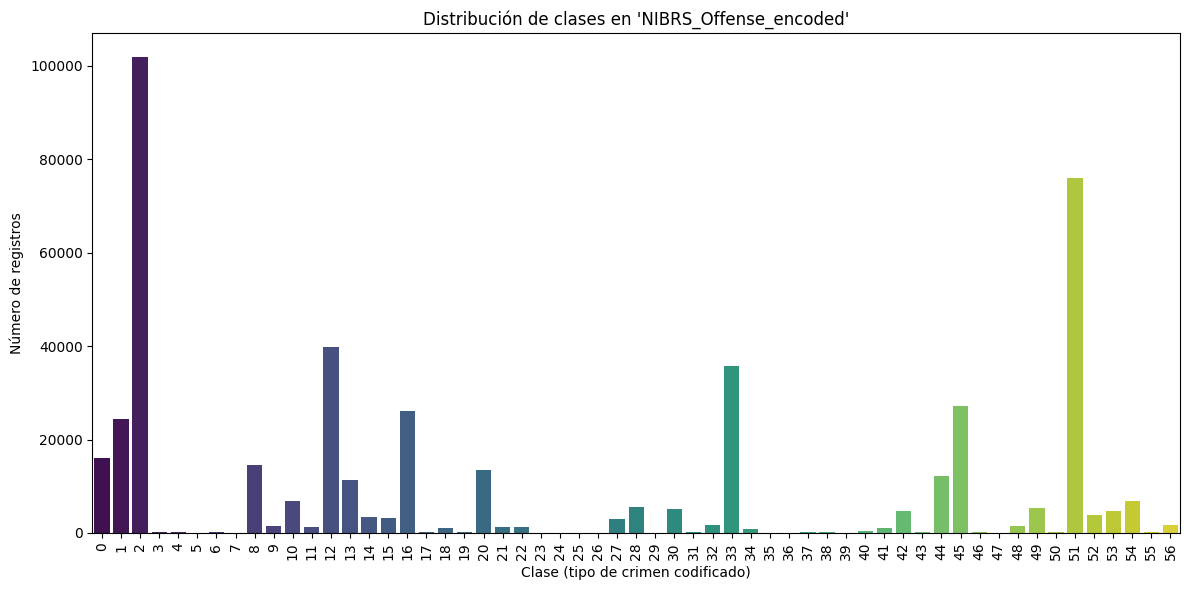


Entrenando modelo combinado...
Entrenando modelo combinado (Random Forest + RNN embeddings)...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

✅ Mejor modelo combinado encontrado: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🔍 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12805
           1       1.00      1.00      1.00     19477
           2       1.00      1.00      1.00     81560
           3       1.00      1.00      1.00       222
           4       1.00      1.00      1.00       154
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       130
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00     11611
           9       1.00      1.00      1.00      1244
          10       1.00      1.00      1.00      5426
          11    

✅ Modelo fusion ok.
✅ Escaler ok.
✅ rnn ok.
✅ Modelos exportados correctamente.


In [5]:
# Ejemplo de uso
if __name__ == "__main__":
    # Reemplazar con la ruta real de tu archivo CSV
    csv_path = "AxonCrimeData_Export_WA_1686331975127960619 (1).csv"
    
    # Para usar el código, descomenta la siguiente línea y ajusta la ruta:
    trained_model, processed_data, performance_metrics = main_with_real_data(csv_path)